In [1]:
def orientation_ratio(angles, dtheta=60):
    """Returns the ratio of angles within +/- dtheta 
    
    angles: [array] of floats or ints
    dtheta : [float] or [int]
    """
    is_oriented = np.abs(angles) <= dtheta
    n_oriented_angles = np.sum(is_oriented)
    
    ratio_oriented = n_oriented_angles/len(angles)
    
    return ratio_oriented

def orientation_percent(angles, dtheta=60):
    """Returns the percentage of angles within +/- dtheta
    
    angles: [array] of floats or ints
    dtheta : [float] or [int]
    """
    return orientation_ratio(angles, dtheta)*100
    
def sample_proportion_error(p, n):
    """Returns the error for a sample proportion
    
    p: [float] 
        Proportion
    n: [int]
        Number of datapoints
    """
    return np.sqrt(p*(1-p) / n)

## Hypothesis test: difference between two proportions
## http://stattrek.com/hypothesis-test/difference-in-proportions.aspx

def pooled_sample_proportion(p1, p2, n1, n2):
    """Returns the pooled sample proportion between two proportions
    
    p1, p2: [float] or [int]
        proportion (first and second)
    n1, n2: [int]
        Sample size associated with p1 and p2
    """
    return (p1*n1 + p2*n2) / (n1 + n2)

def standard_error_between_two_proportions(p, n1, n2):
    """Returns the standard error between two proportions
    
    p: [float] or [int]
        Pooled sample proportion
    n1, n2: [int]
        Sample size in first and second experiment
    """
    return np.sqrt(p * (1 - p) * (1./n1 + 1./n2) )

def z_score_between_two_proportions(p1, p2, SE):
    """Returns the z-score between two proportions
    
    p1, p2: [float] or [int]
        Proportion (first and second)
    SE: [float] or [int]
        Standard error between two proportions
    """
    return (p1 - p2) / SE



def plot_barchart(wild_orientation_percent, mutant_orientation_percent,
                            wild_errors, mutant_errors, wild_n, mutant_n, colors,
                            experiment, orientation_angle, plots_dir, times, ax):
    
    n_groups = len(times) # 3
    index = np.arange(n_groups)
    bar_width = 0.4

    kwargs = {'alpha': 0.85,
              'capsize': 5,
              'edgecolor': 'k',
              'linewidth': 1
             }
    
    def autolabel(rects):
        """ Attach a text label on each bar displaying its height
    
         Shamelessly adapted from
         https://matplotlib.org/examples/api/barchart_demo.html
        """
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 0.7*height,
                    '{}'.format(int(height)),
                    ha = 'center', va = 'bottom',
                    size = 15)
    
    rects_wild = ax.bar(index, wild_orientation_percent,
                        bar_width,
                        color = colors['Wild Type'],
                        label = 'Wild Type',
                        yerr = wild_errors,
                        **kwargs
                       )

    rects_mutant = ax.bar(index + bar_width, mutant_orientation_percent,
                          bar_width,
                          color = colors['Mutant DEE/DEE'],
                          label ='Mutant DEE/DEE',
                          yerr = mutant_errors,
                          **kwargs
                         )

    autolabel(rects_wild)
    autolabel(rects_mutant)
    
    ax.set_xlabel("Time")
    ax.set_ylabel("Orientation %")
    ax.set_title("Golgi Polarization {} with {} deg".format(
        experiment, orientation_angle))
    ax.set_xticks(index + bar_width/2)
    ax.set_xticklabels(tuple(times))
    ax.set_ylim([0, 100])
    ax.legend(fontsize = 15)
    
    return None

def plot_table(wild_orientation_percent, wild_errors, mutant_orientation_percent, mutant_errors,
              wild_n, mutant_n, ax):
    
    table_columns = ('2 hrs', '4 hrs', '6 hrs', '2 hrs', '4 hrs', '6 hrs')
    #table_columns = ('2 hrs', '4 hrs','2 hrs', '4 hrs')
    rows = ['N', r'Oriented [%]', r'std err [%]']
    
    table_data = [wild_n + mutant_n,
                  [int(x) for x in wild_orientation_percent + mutant_orientation_percent],
                  [int(x) for x in wild_errors + mutant_errors]]
    ## We can cast the percentages above to ints since the errors are around 3% minimum
    
    table = ax.table(cellText = table_data,
                        colWidths = [0.1]*6,
                     #colWidths = [0.1]*4,
                        colLabels = table_columns,
                        rowLabels = rows,
                        loc='center'
                       )
    
    table.set_fontsize(17)
    table.scale(1.5, 1.5)
    ax.axis('off')
    
    return None

def make_and_save_barchart_with_table(wild_orientation_percent, mutant_orientation_percent,
                            wild_errors, mutant_errors, wild_n, mutant_n, colors,
                            experiment, orientation_angle, plots_dir, times):
    plt.close('all')
    fig, axes = plt.subplots(2,1, figsize=(12,12))
    
    plot_table(wild_orientation_percent, wild_errors, mutant_orientation_percent, mutant_errors,
              wild_n, mutant_n, axes[0])
    
    
    plot_barchart(wild_orientation_percent, mutant_orientation_percent,
                            wild_errors, mutant_errors, wild_n, mutant_n, colors,
                            experiment, orientation_angle, plots_dir, times, axes[1])
    
    plt.savefig('{}{}_{}deg.png'.format(plots_dir, experiment, orientation_angle))
    plt.close(fig)
    return None

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#plt.style.use('ggplot')
import seaborn as sns
sns.set_style("whitegrid")
plt.rc('axes', titlesize = 16)
plt.rc('axes', labelsize = 16)
plt.rc('xtick', labelsize = 15)
plt.rc('ytick', labelsize = 15)

from glob import glob
import os
import statsmodels.api as sm

def main():
    ## Initialize experiment-related knowledge
    exp_names = ['exp-1', 'exp-3']#, 'exp-4']

    unblinding_key = {'exp-1': {'Wild Type'      : 'Animal 1',
                                'Mutant DEE/DEE' : 'Animal 2'}
                      ,
                      'exp-3': {'Wild Type'      : 'Animal 2',
                                'Mutant DEE/DEE' : 'Animal 1'}
                      ,
                      'exp-4': {'Wild Type'      : 'Animal 2',
                                'Mutant DEE/DEE' : 'Animal 1'}
                     }

    csv_dir = r'../data/csvfiles/'
    plots_dir = r'../plots/'

    times = ['2hrs', '4hrs', '6hrs']
    #times = ['2hrs', '4hrs']

    colors = {'Wild Type'      : 'purple', 
              'Mutant DEE/DEE' : 'blue'}

    ## Choice of angle here
    orientation_angle_list = np.arange(35, 65, 5)
    

    ## Initialize lists that will become dataframes later
    all_p_value_list = []
    all_times_list = []
    all_orientation_list = []
    all_exp_list = []
    all_z_scores_list = []
    all_SE_list = []
    
    for experiment in exp_names:    
        csv_file = os.path.join(csv_dir, "{}data.csv".format(experiment))
        df = pd.read_csv(csv_file)
        
        ## Add new columns to be used later
        df['animal_id'] = df.fileID.str.split('_', expand=True).get(0)
        df['time'] = df.fileID.str.split('_', expand=True).get(1).str.lower()

        new_df = df.filter(['golgiAreaInSquareMicrons',
                            'anglesInDeg',
                            'nucleiAreaInSquareMicrons',
                            'time',
                            'animal_id'],
                           axis = 1
                          )

        ## area cut - keep data with golgi area between (10, 100) microns^2
        area_above_10_microns_squared  = new_df['golgiAreaInSquareMicrons'] > 10
        area_below_100_microns_squared = new_df['golgiAreaInSquareMicrons'] < 100

        golgi_area_cut = area_above_10_microns_squared & area_below_100_microns_squared

        ## Split into wild type and mutant dataframes
        is_wild_type = new_df.animal_id == unblinding_key[experiment]['Wild Type']
        is_mutant = new_df.animal_id == unblinding_key[experiment]['Mutant DEE/DEE']

        wild_type = new_df[golgi_area_cut & is_wild_type]
        mutant    = new_df[golgi_area_cut & is_mutant]

        for orientation_angle in orientation_angle_list:
            # Initialize list containers
            wild_n_list = []
            mutant_n_list = []
            wild_orientation_percent_list = []
            mutant_orientation_percent_list = []
            wild_error_list = []
            mutant_error_list = []
            pvalue_list = []

            for time in times:
                # Split by time
                wild_at_this_time = wild_type[wild_type.time == time]
                mutant_at_this_time = mutant[mutant.time == time]

                n_wild = len(wild_at_this_time)
                n_mutant = len(mutant_at_this_time)

                # Calculate the percent oriented for wild/mutant
                orientation_percent_wild = orientation_percent(wild_at_this_time['anglesInDeg'],
                                                              dtheta=orientation_angle)
                orientation_percent_mutant = orientation_percent(mutant_at_this_time['anglesInDeg'],
                                                                dtheta=orientation_angle)

                ratio_wild = orientation_percent_wild/100.
                ratio_mutant = orientation_percent_mutant/100.

                ## Rest of loop section is appending to lists
                wild_n_list.append(n_wild)
                mutant_n_list.append(n_mutant)

                wild_orientation_percent_list.append(orientation_percent_wild)
                mutant_orientation_percent_list.append(orientation_percent_mutant)

                wild_error_list.append(sample_proportion_error(ratio_wild, n_wild)*100)
                mutant_error_list.append(sample_proportion_error(ratio_mutant, n_mutant)*100)

                all_times_list.append(time)

            ## Generate plots for different angle orientations
            make_and_save_barchart_with_table(wild_orientation_percent_list,
                                              mutant_orientation_percent_list,
                                              wild_error_list, mutant_error_list,
                                              wild_n_list, mutant_n_list, colors,
                                              experiment, orientation_angle,
                                              plots_dir, times
                                             )

            ## Get numpy arrays of ratios and sample sizes
            p_wild = np.array(wild_orientation_percent_list)/100.
            p_mutant = np.array(mutant_orientation_percent_list)/100.

            n_wild = np.array(wild_n_list)
            n_mutant = np.array(mutant_n_list)

            ## We satisfy the criteria for Z tests
            p = pooled_sample_proportion(p_wild, p_mutant, n_wild, n_mutant)
            SE = standard_error_between_two_proportions(p, n_wild, n_mutant)
            z_scores = z_score_between_two_proportions(p_wild, p_mutant, SE)

            from scipy import special
            p_values = 1 - special.ndtr(z_scores)

            ## Rest is extending
            all_p_value_list.extend(p_values)
            all_orientation_list.extend([orientation_angle]*3)
            all_exp_list.extend([experiment]*3)
            all_SE_list.extend(SE)
            all_z_scores_list.extend(z_scores)


    ## Create pandas DataFrame
    d = {"p_value"           : all_p_value_list,
         "Orientation Angle" : all_orientation_list,
         "Time"              : all_times_list,
         "Experiment"        : all_exp_list,
         "z_score"           : all_z_scores_list,
         "Standard_error"    : all_SE_list,
        }

    df = pd.DataFrame(d)
    df.to_csv("../data/csvfiles/p_values.csv".format(experiment),
             index = False)
    
    ## Split by experiment
    exp1 = df[df['Experiment'] == 'exp-1']
    exp3 = df[df['Experiment'] == 'exp-3']
    #exp4 = df[df['Experiment'] == 'exp-4']

    ## Change index to Orientation Angle
    ## Orientation Angle will be our 'x-axis' in our p-value plot
    exp1.set_index('Orientation Angle', inplace=True)
    exp3.set_index('Orientation Angle', inplace=True)
    #exp4.set_index('Orientation Angle', inplace=True)
    
    ## Generate p-value plots
    plt.close('all')
    fig, axes = plt.subplots(2,1,figsize=(12,12), sharex=True)
    ax = axes.ravel()

    exp1.groupby('Time')['p_value'].plot(legend=True, ax=ax[0])

    ax[0].set_yscale('log')
    ax[0].set_title('exp 1')
    ax[0].set_xticks(np.arange(35, 65, 5))
    ax[0].set_ylabel('p-value')
    ax[0].axhline(0.05, ls="--", label='0.05')
    ax[0].legend()

    exp3.groupby('Time')['p_value'].plot(legend=True, ax=ax[1])

    ax[1].set_yscale('linear')
    ax[1].set_title('exp 3')
    #ax[1].set_xlabel('Orientation Angle [deg]')
    ax[1].set_ylabel('p-value')
    ax[1].axhline(0.05, ls="--", label='0.05')
    ax[1].legend()

    #exp4.groupby('Time')['p_value'].plot(legend=True, ax=ax[2])
    #ax[2].set_yscale('linear')
    #ax[2].set_title('exp 4')
    #ax[2].set_xlabel('Orientation Angle [deg]')
    #ax[2].set_ylabel('p-value')
    #ax[2].axhline(0.05, ls="--", label='0.05')
    #ax[2].legend()
    #plt.savefig('{}p_values_vs_angles.png'.format(plots_dir))

#if __name__ == "main":
#    main()

C:\Users\letmedoit\Anaconda3\envs\myWindowsCV\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


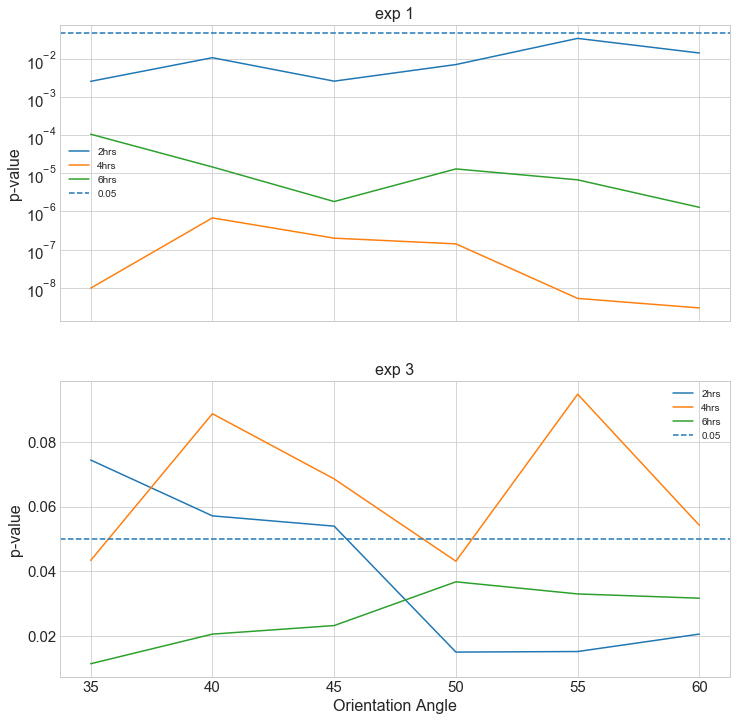

In [3]:
main()

In [4]:
def get_ID_from_filename(filename):
    """returns a unique ID for an animal in a litter
    
    Sample input: "../outgrowth\\Results_42-2-1.csv"
    Sample output: "42-2"
    """
    ID_list = filename.split("Results_")[-1].split("-")[0:2]
    ID = "-".join(ID_list)
    
    return ID

def read_csv_and_add_ID_to_df(filename):
    """returns a Pandas dataframe with Angle and ID as its columns"""
    temp_df = pd.read_csv(filename, usecols=["Angle"])
    temp_df["ID"] = get_ID_from_filename(filename)
    return temp_df

exp_4_data_csvs = glob("../data/exp-4-angles/*.csv")
list_of_dfs = [read_csv_and_add_ID_to_df(f) for f in exp_4_data_csvs]
csv_df = pd.concat(list_of_dfs, ignore_index = True)
csv_df.head()

,Angle,ID
0,14.444,1-2
1,-145.408,1-2
2,6.911,1-2
3,-48.814,1-2
4,-24.656,1-2


Text(0.5,1,'Exp-4')

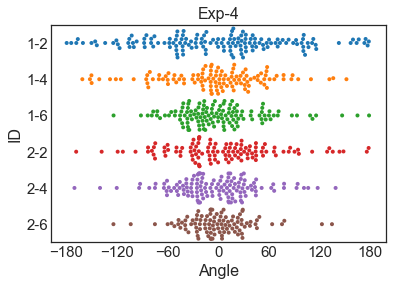

In [21]:
import seaborn as sns

ax = sns.swarmplot(x="Angle", y="ID", data=csv_df, size=4)
ax.set_xticks(np.arange(-180,180+60,60))
ax.set_title("Exp-4")

In [9]:
def get_p_value(ratios, n, wild_type_ID, mutant_ID):
    from scipy import special
    proportion = pooled_sample_proportion(ratios[wild_type_ID],
                                         ratios[mutant_ID],
                                         n[wild_type_ID],
                                         n[mutant_ID])
    SE = standard_error_between_two_proportions(proportion,
                                               n[wild_type_ID],
                                               n[mutant_ID])
    z_score = z_score_between_two_proportions(ratios[wild_type_ID],
                                             ratios[mutant_ID],
                                             SE)
    p_value = 1 - special.ndtr(z_score)
    
    return p_value

In [10]:
def get_summary_df(df, angle, want_csv_file=False):
    ratios = df.groupby("ID")["Angle"].apply(orientation_ratio, angle)
    #print(ratios["2-2"])
    n = df.groupby("ID").size()
    SPE = sample_proportion_error(ratios, n)
    df_summary = pd.DataFrame({"ratios":ratios,
                              "n":n,
                              "sample_proportion_error":SPE})
    df_summary["hours"] = ["2", "4", "6", "2", "4", "6"]
    df_summary["Genotype"] = ["DEE/DEE Mutant", "DEE/DEE Mutant", "DEE/DEE Mutant",
                          "Wild type", "Wild type", "Wild type"]
    df_summary.reset_index(inplace=True)
    if want_csv_file:
        df_summary.to_csv("exp4_data_summary_{}degrees.csv".format(angle),
                          index = False)
        
    print("2 hour p-value: {}".format(get_p_value(ratios, n, "2-2","1-2")))
    print("4 hour p-value: {}".format(get_p_value(ratios, n, "2-4","1-4")))
    print("6 hour p-value: {}".format(get_p_value(ratios, n, "2-6","1-6")))
    return df_summary

In [11]:
angle = 60
df_summary = get_summary_df(csv_df, angle, want_csv_file = True)
df_summary

2 hour p-value: 0.007905505677616165
4 hour p-value: 0.07333525387866857
6 hour p-value: 0.009870876446098409


,ID,n,ratios,sample_proportion_error,hours,Genotype
0,1-2,147,0.571429,0.040816,2,DEE/DEE Mutant
1,1-4,117,0.735043,0.040799,4,DEE/DEE Mutant
2,1-6,125,0.816000,0.034658,6,DEE/DEE Mutant
3,2-2,113,0.716814,0.042384,2,Wild type
4,2-4,128,0.812500,0.034499,4,Wild type
5,2-6,103,0.922330,0.026372,6,Wild type


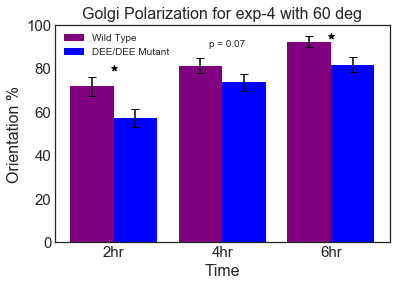

In [16]:
import seaborn as sns
sns.set_style("white")

N = 3
ind = np.arange(N)

mutant_means = tuple(df_summary["ratios"][0:3].values*100.)
mutant_spes = tuple(df_summary["sample_proportion_error"][0:3].values*100.)

wild_means = tuple(df_summary["ratios"][3:6].values*100.)
wild_spes = tuple(df_summary["sample_proportion_error"][3:6].values*100.)

width = 0.4

fig, ax = plt.subplots()

rects_wild = ax.bar(ind, wild_means,
                    width, color='purple',
                    yerr=wild_spes,
                   capsize=4)

rects_mutant = ax.bar(ind+width, mutant_means,
                      width, color='blue',
                      yerr=mutant_spes,
                     capsize=4)


ax.set_xticks(ind + width / 2)
ax.set_xticklabels(("2hr", "4hr", "6hr"))
ax.set_xlabel("Time")
ax.set_ylabel("Orientation %")
ax.set_ylim([0, 100])
ax.set_title("Golgi Polarization for exp-4 with {} deg".format(angle))

## Add the markers for designating p < 0.01
ax.scatter(width/2, 80, marker="*", c="black")
ax.scatter(2 + width/2, 95, marker="*", c="black")

ax.annotate("p = 0.07", xy=(1 + width/5, 90))
ax.legend((rects_wild, rects_mutant), ('Wild Type', 'DEE/DEE Mutant'))
plt.savefig("../plots/exp4_{}deg.png".format(angle))
plt.savefig("../plots/exp4_{}deg.pdf".format(angle))

In [17]:
angle=45

df_summary = get_summary_df(csv_df, angle, want_csv_file = True)
df_summary

2 hour p-value: 0.0018268003256889376
4 hour p-value: 0.005645951701657492
6 hour p-value: 0.012287960746320992


,ID,n,ratios,sample_proportion_error,hours,Genotype
0,1-2,147,0.455782,0.041078,2,DEE/DEE Mutant
1,1-4,117,0.589744,0.045474,4,DEE/DEE Mutant
2,1-6,125,0.720000,0.040160,6,DEE/DEE Mutant
3,2-2,113,0.637168,0.045231,2,Wild type
4,2-4,128,0.742188,0.038664,4,Wild type
5,2-6,103,0.844660,0.035691,6,Wild type


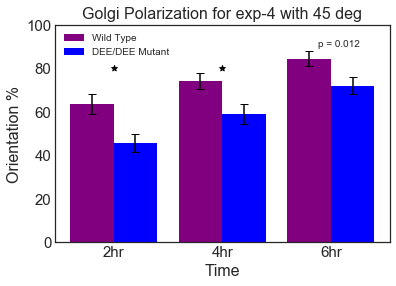

In [20]:
mutant_means = tuple(df_summary["ratios"][0:3].values *100.)
mutant_spes = tuple(df_summary["sample_proportion_error"][0:3].values*100.)

wild_means = tuple(df_summary["ratios"][3:6].values*100.)
wild_spes = tuple(df_summary["sample_proportion_error"][3:6].values*100.)

width = 0.4

fig, ax = plt.subplots()

rects_wild = ax.bar(ind, wild_means,
                    width, color='purple',
                    yerr=wild_spes,
                   capsize=4)

rects_mutant = ax.bar(ind+width, mutant_means,
                      width, color='blue',
                      yerr=mutant_spes,
                     capsize=4)


ax.set_xticks(ind + width / 2)
ax.set_xticklabels(("2hr", "4hr", "6hr"))
ax.set_xlabel("Time")
ax.set_ylabel("Orientation %")
ax.set_ylim([0, 100])
ax.set_title("Golgi Polarization for exp-4 with {} deg".format(angle))

## Add the markers for designating p < 0.01
ax.scatter(width/2, 80, marker="*", c="black")
ax.scatter(1 + width/2, 80, marker="*", c="black")

ax.annotate("p = 0.012", xy=(2 + width/5, 90))
ax.legend((rects_wild, rects_mutant), ('Wild Type', 'DEE/DEE Mutant'))

plt.savefig("../plots/exp4_{}deg.png".format(angle))
plt.savefig("../plots/exp4_{}deg.pdf".format(angle))